In [1254]:
# Evolutionary algorithm

import networkx as nx
import numpy as np
from pyswarm import pso
import matplotlib.pyplot as plt
import math
from random import randint, uniform
import copy


In [1255]:
def generateNewValue(lim1, lim2):
    return uniform(lim1, lim2)


def binToInt(x):
    val = 0
    # x.reverse()
    for bit in x:
        val = val * 2 + bit
    return val


In [1256]:
from random import randint, seed


def generateARandomPermutation(n):
    perm = [i for i in range(n)]
    for i in range(n):
        pos1 = randint(0, n - 1)
        pos2 = randint(0, n - 1)
        perm[pos1], perm[pos2] = perm[pos2], perm[pos1]
    return perm

# print(generateARandomPermutation(10))
# print(generateARandomPermutation(10))
# if we fix the seed, we obtain the same results for all runs
# seed(5)
# print(generateARandomPermutation(10))
# print(generateARandomPermutation(10))

In [1257]:
# paths = ["./data/real/" + name + "/" + name + ".gml" for name in ["dolphins", "football", "karate", "krebs"]]

In [1258]:
class Chromosome:
    def __init__(self, network, problParam=None):
        self.__problParam = problParam
        self.__repres = self.init_repres(network)
        self.__fitness = 99999

    def init_repres(self, network):

        mat = network["mat"]

        return generateARandomPermutation(len(mat))

    @property
    def repres(self):
        return self.__repres

    @property
    def fitness(self):
        return self.__fitness

    @repres.setter
    def repres(self, l=[]):
        self.__repres = l

    @fitness.setter
    def fitness(self, fit=0.0):
        self.__fitness = fit

    def crossover(self, c, network):
        
        # search for a common point index in the 2 chromosomes
        # commonPointIndex = 0
        # for index in range(len(self.__repres)):
        #     if(self.__repres[index] == c.__repres[index]):
        #         commonPointIndex = index
        #         break
        # c1 = Chromosome(network, self.__problParam)
        # c1.__repres = self.__repres
        # # from there, switch the values
        # for index in range(commonPointIndex, len(self.__repres)):
        #     c1.__repres[index] = c.__repres[index]

        # find a list of common indexes
        commonIndexes = []
        for index in range(len(self.__repres)):
            if(self.__repres[index] == c.__repres[index]):
                commonIndexes.append(index)
        # go through these common indexes and switch them around
        c1 = Chromosome(network, self.__problParam)
        # now do a permutation of the commonIndexes list
        permIndexes = generateARandomPermutation(len(commonIndexes))
        c1.__repres = self.__repres
        for index in range(len(commonIndexes)):
            c1.__repres[commonIndexes[index]] = c.__repres[permIndexes[index]]

        return c1

    def shuffle(self, list: list):
        for i in range(len(list) - 1, 0, -1):
            j = randint(0, i)
            list[i], list[j] = list[j], list[i]
        return list

    def mutation(self, pm):
        """
        Mutation of a chromosome
        :param pm: probability of mutation
        """
        if uniform(0, 1) <= pm:
            pos1 = randint(0, len(self.__repres) - 1)
            pos2 = randint(0, len(self.__repres) - 1)
            if pos1 > pos2:
                # switch
                pos2, pos1 = pos1, pos2
            # print(self.__repres[pos1:pos2])
            self.__repres[pos1:pos2] = self.shuffle(self.__repres[pos1:pos2])
            # print(self.__repres[pos1:pos2])
    def differentFrom(self, c):
        for index in range(len(self.__repres)):
            if(self.__repres[index] == c.__repres[index]):
                return False
        return True
    def copyRepres(self, c):
        for index in range(len(self.__repres)):
            self.__repres[index] = c.__repres[index]
    def evaluate(self, network):
        cost = 0
        road = self.__repres
        for nodeIndex in range(len(road) - 1):
            i = road[nodeIndex]
            j = road[(nodeIndex + 1)]
            cost += network["mat"][i][j]
        cost += network["mat"][0][road[-1]]
        return cost
    def __str__(self):
        return "\nChromo: " + str(self.__repres) + " has cost: " + str(self.__fitness)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness


In [1259]:
class GeneticAlgorithm:
    def __init__(self, network, param=None, problParam=None):
       
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        self.__network = network
        self.__bestEver = None

    def bestEver(self):
        return self.__bestEver
    @property
    def population(self):
        """
        Get method for population
        :return: population
        """
        return self.__population

    def initialisation(self):
        """
        intialize population
        """
        for _ in range(0, self.__param["popSize"]):
            c = Chromosome(self.__network, self.__problParam)
            self.__population.append(c)
        self.evaluation()
        self.__bestEver = Chromosome(self.__network, self.__problParam)
        self.__bestEver.copyRepres(self.bestChromosome())

    def evaluation(self):
        """
        Population evaluation
        """
        for c in self.__population:
            c.fitness = self.__problParam["function"](c.repres, self.__network)

    def worstChromosome(self):
        """
        Worst fitness
        :return: worst fitness chromosome
        """
        worst = self.__population[0]
        for c in self.__population:
            if c.fitness > worst.fitness:
                worst = c
        return worst

    def bestChromosome(self):
        """
        Best fitness
        :return: best fitness chromosome
        """
        best = self.__population[0]
        for c in self.__population:
            if c.fitness < best.fitness:
                best = c
        return best

    def selection(self):
        """
        Returns the better chromosome
        :return: better chromosome
        """
        # pos1 = randint(0, self.__param["popSize"] - 1)
        # pos2 = randint(0, self.__param["popSize"] - 1)
        # if self.__population[pos1].fitness < self.__population[pos2].fitness:
        #     return pos1
        # else:
        #     return pos2
        # take 20 of the lowest fitness chromosomes
        # and select a random one
        # code:
        # sort the population by fitness
        self.__population.sort(key=lambda x: x.fitness)
        # take the first 20
        pop = self.__population[:20]
        # select a random one
        pos = randint(0, len(pop) - 1)
        return self.__population.index(pop[pos])

    def oneGeneration(self):
        """
        Generate chromosomes every new generation
        """
        newPop = []
        for _ in range(self.__param["popSize"]):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2, self.__network)
            off.mutation(self.__param["pm"])
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        """
        Remain only the best chromosomes - Elitism
        """
        best = self.bestChromosome()
        if( best.fitness < self.__bestEver.fitness):
            print("Found new bestever with fitness: " , best.fitness)
            self.__bestEver.copyRepres(best)
            self.__bestEver.fitness = best.fitness
        newPop = []
        # sort population based on fitness
        self.__population.sort(key=lambda x: x.fitness)
        for i in range(10):
            newPop.append(self.__population[i])
        for _ in range(self.__param["popSize"] - 11):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = Chromosome(self.__network, self.__problParam)
            off.copyRepres(p1)
            off.mutation(self.__param["pm"])
            # off = off.crossover(p2, self.__network)
            # off.mutation(self.__param["pm"])
            # off.evaluate(self.__network)
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationSteadyState(self):
        """
        Steady State
        """
        for _ in range(self.__param["popSize"]):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2, self.__network)
            off.mutation(self.__param["pm"])
            off.fitness = self.__problParam["function"](off.repres, self.__network)
            worst = self.worstChromosome()
            if off.fitness > worst.fitness:
                worst = off

In [1260]:
def draw_graph(G, communities):

    node_groups = []
    for item in range(max(communities) + 1):
        node_groups.append([])
    for node in range(len(communities)):
        node_groups[communities[node]].append(node)

    # print(node_groups)

    color_map = []
    nrcommunities = len(node_groups)
    colors = [
        "red",
        "green",
        "blue",
        "yellow",
        "orange",
        "purple",
        "pink",
        "brown",
        "black",
        "grey",
    ]
    for node in range(len(G.nodes())):
        for node_group in range(nrcommunities):
            if node in node_groups[node_group]:
                color_map.append(colors[node_group])
    plt.figure(figsize=(20, 20))
    nx.draw_networkx(
        G, pos=nx.spring_layout(G), node_color=color_map, with_labels=False
    )
    # nx.draw(G, pos=nx.spring_layout(G), node_color=color_map, with_labels=False, node_size=500)
    # nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_color=color_map)
    # nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5, edge_color = "black")
    plt.show()



def fitnessRoad(road, network):
    # this fitness function is defined as the sum of the costs of the edges the chromosome chose
    # the lower the cost, the better the fitness
    cost = 0
    for nodeIndex in range(len(road) - 1):
        i = road[nodeIndex]
        j = road[(nodeIndex + 1)]
        cost += network["mat"][i][j]
    cost += network["mat"][0][road[-1]]
    return cost


In [1261]:
def getDegrees(G):
    return [d for n, d in G.degree()]
def adapt_numpy_matrix(network):
    # for every element in the matrix, if it is 0, it will be replaced with a big value
    # this is done because the algorithm will not work with 0 values
    for i in range(len(network['mat'])):
        for j in range(len(network['mat'][i])):
            if network['mat'][i][j] == 0:
                network['mat'][i][j] = 99

In [1262]:
def do_road(path, gens=50, readFromGML=True):
    G = None
    noNodes = 0
    mat = None
    if readFromGML:
        G = nx.read_gml(path)
        noNodes = len(G.nodes())
        mat = nx.to_numpy_array(G)
    else:
        with open(path, "r") as f:
            noNodes = int(f.readline())
            # read mat as numpy array
            mat = np.loadtxt(f, dtype=int, skiprows=0, max_rows=noNodes,delimiter=',')
            
    # print(costs)

    network = {"noNodes": noNodes, "mat": mat}
    if readFromGML:
        adapt_numpy_matrix(network)
    noGen = gens

    # xref = [[utils.generateNewValue(0, numComms - 1) for _ in range(noDim)] for _ in range(0, 1000)]
    # xref.sort()
    # yref = [fcEval(xi) for xi in xref]

    param = {"popSize": 100, "noGen": noGen, "pm": 0.2, "pc": 0.5}

    problParam = {"function": fitnessRoad, "noDim": len(network)}

    allBestFitnesses = []
    allAvgFitnesses = []
    generations = []

    ga = GeneticAlgorithm(network, param, problParam)
    ga.initialisation()
    ga.evaluation()

    bestChrom = None
    fitnessValues = []
    for g in range(param["noGen"]):
        ga.oneGenerationElitism()
        
        bestChrom = ga.bestChromosome()
        fitnessValues.append(bestChrom.fitness)
    bestChrom = ga.bestEver()
    bestFitness = bestChrom.fitness
    bestChroms = [bestChrom]
    for fitIndex in range(len(ga.population)):
        if ga.population[fitIndex].fitness == bestFitness and ga.population[fitIndex].differentFrom(bestChrom):
            bestChroms.append(ga.population[fitIndex])

    plt.plot(fitnessValues)
    return bestChroms


Found new bestever with fitness:  8.0


[
 Chromo: [7, 5, 1, 2, 0, 6, 3, 4] has cost: 8.0,
 
 Chromo: [2, 0, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [3, 6, 0, 4, 2, 1, 7, 5] has cost: 8.0,
 
 Chromo: [0, 6, 4, 1, 2, 3, 7, 5] has cost: 8.0,
 
 Chromo: [0, 1, 7, 6, 3, 4, 5, 2] has cost: 8.0,
 
 Chromo: [4, 6, 3, 5, 7, 1, 0, 2] has cost: 8.0,
 
 Chromo: [6, 0, 4, 1, 2, 3, 7, 5] has cost: 8.0,
 
 Chromo: [0, 1, 7, 6, 3, 4, 5, 2] has cost: 8.0,
 
 Chromo: [2, 0, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [0, 2, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [2, 0, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [2, 0, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [4, 0, 3, 6, 7, 2, 1, 5] has cost: 8.0,
 
 Chromo: [0, 6, 4, 1, 2, 3, 7, 5] has cost: 8.0,
 
 Chromo: [0, 6, 4, 1, 2, 3, 7, 5] has cost: 8.0,
 
 Chromo: [2, 0, 4, 1, 5, 3, 6, 7] has cost: 8.0,
 
 Chromo: [4, 6, 3, 5, 7, 1, 0, 2] has cost: 8.0,
 
 Chromo: [4, 6, 3, 5, 7, 1, 0, 2] has cost: 8.0,
 
 Chromo: [0, 6, 4, 1, 2, 3, 7, 5] has cost: 8.0,
 
 Chromo: [6, 0, 4, 1, 2, 3, 7

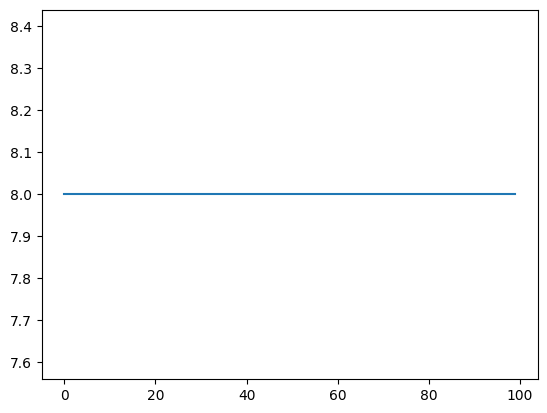

In [1263]:
path = "./datasets/complete.gml"
do_road(path, 100)

Found new bestever with fitness:  10


[
 Chromo: [3, 2, 1, 0] has cost: 10]

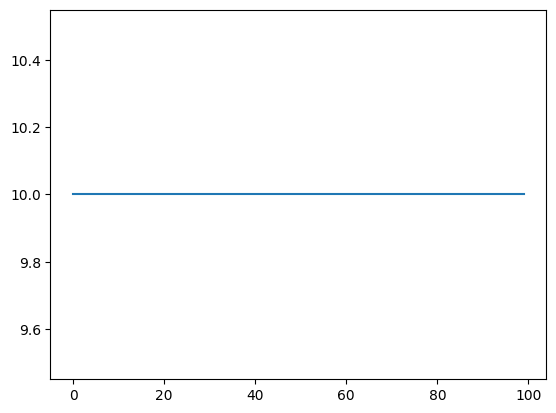

In [1264]:
path = "./datasets/easy_01_tsp.txt"
do_road(path, 100, False)

Found new bestever with fitness:  22


[
 Chromo: [2, 1, 3, 0] has cost: 22]

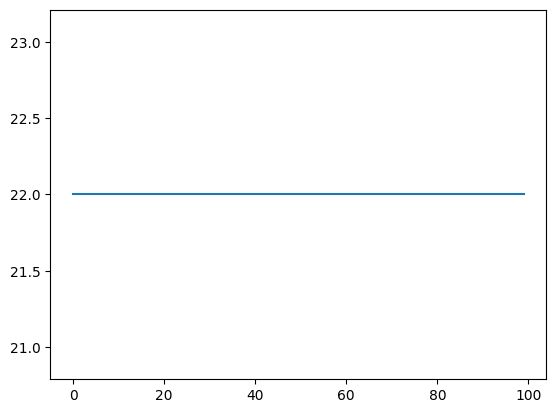

In [1265]:
path = "./datasets/t6.tsp"
do_road(path, 100, False)

Found new bestever with fitness:  2096
Found new bestever with fitness:  2088
Found new bestever with fitness:  2042
Found new bestever with fitness:  2037
Found new bestever with fitness:  1994
Found new bestever with fitness:  1992
Found new bestever with fitness:  1979
Found new bestever with fitness:  1939
Found new bestever with fitness:  1929
Found new bestever with fitness:  1928
Found new bestever with fitness:  1820
Found new bestever with fitness:  1758
Found new bestever with fitness:  1738
Found new bestever with fitness:  1703
Found new bestever with fitness:  1670
Found new bestever with fitness:  1575
Found new bestever with fitness:  1568
Found new bestever with fitness:  1546
Found new bestever with fitness:  1536
Found new bestever with fitness:  1519
Found new bestever with fitness:  1474
Found new bestever with fitness:  1473
Found new bestever with fitness:  1457
Found new bestever with fitness:  1433


[
 Chromo: [23, 0, 1, 2, 7, 6, 4, 3, 8, 9, 10, 14, 13, 5, 15, 18, 19, 17, 16, 12, 11, 20, 25, 22, 24, 21] has cost: 1433]

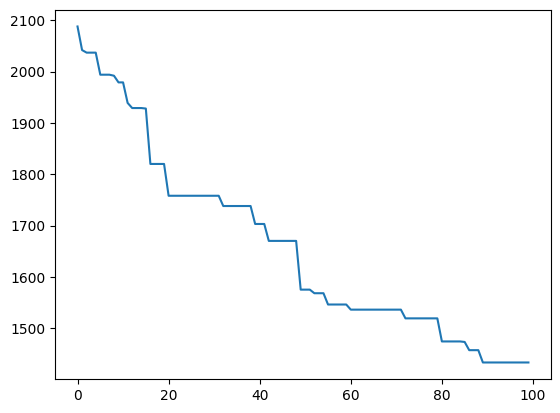

In [1266]:
path = "./datasets/th.tsp"
do_road(path, 100, False)

In [1267]:
# create a file that contains a generated directed cost graph
def createFile(numNodes):
    with open("datasets/hard.txt", "w") as f:
        f.write(str(numNodes) + "\n")
        # generate a random array of costs with numNodes * numNodes elements
        costs = np.random.randint(0, 100, size=(numNodes, numNodes))
        # write the costs in the file, separated by ,
        for i in range(numNodes):
            for j in range(numNodes):
                f.write(str(costs[i][j]))
                if j != numNodes - 1:
                    f.write(",")
            f.write("\n")
    

In [1268]:
createFile(150)

Found new bestever with fitness:  6733
Found new bestever with fitness:  6613
Found new bestever with fitness:  6521
Found new bestever with fitness:  6514
Found new bestever with fitness:  6318
Found new bestever with fitness:  6218
Found new bestever with fitness:  6212
Found new bestever with fitness:  6134
Found new bestever with fitness:  5977
Found new bestever with fitness:  5964
Found new bestever with fitness:  5838
Found new bestever with fitness:  5812
Found new bestever with fitness:  5741
Found new bestever with fitness:  5631
Found new bestever with fitness:  5604
Found new bestever with fitness:  5574
Found new bestever with fitness:  5573
Found new bestever with fitness:  5501
Found new bestever with fitness:  5419
Found new bestever with fitness:  5324
Found new bestever with fitness:  5259
Found new bestever with fitness:  5252
Found new bestever with fitness:  5199
Found new bestever with fitness:  5196
Found new bestever with fitness:  5186
Found new bestever with f

[
 Chromo: [24, 139, 65, 9, 22, 2, 53, 7, 43, 51, 10, 114, 12, 98, 14, 6, 49, 54, 18, 15, 56, 125, 59, 135, 74, 0, 106, 52, 117, 104, 45, 67, 116, 141, 122, 62, 108, 143, 16, 29, 81, 47, 121, 50, 148, 84, 75, 23, 8, 111, 147, 76, 128, 88, 90, 89, 57, 124, 66, 48, 20, 113, 138, 31, 41, 58, 80, 133, 83, 120, 70, 102, 130, 103, 3, 97, 28, 137, 109, 126, 140, 36, 55, 35, 33, 26, 132, 27, 34, 86, 79, 145, 96, 40, 134, 105, 63, 69, 11, 93, 100, 110, 127, 44, 119, 82, 99, 101, 129, 136, 123, 71, 85, 46, 73, 4, 17, 39, 77, 118, 144, 91, 146, 21, 78, 38, 115, 72, 149, 142, 68, 64, 112, 95, 94, 131, 87, 32, 37, 1, 19, 5, 25, 107, 61, 60, 13, 42, 92, 30] has cost: 4833]

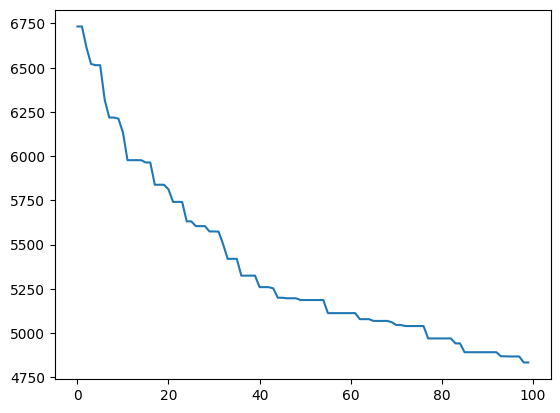

In [1269]:
path = "./datasets/hard.txt"
do_road(path, 100, False)